# Analysis of 5 Algorithms without performing one hot encoding on the dataset

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, auc, precision_recall_curve, roc_curve
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import tensorflow
tensorflow.config.list_physical_devices()

2023-05-03 13:11:53.328007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 13:11:53.784282: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-03 13:11:54.169924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-03 13:11:54.170120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# RNN

In [4]:
# Load the dataset
df = pd.read_csv('bank_fraud_dataset_one_hot_encoded.csv')

print(df.columns)

Index(['amount', 'onehotencoder__customer_C1000148617',
       'onehotencoder__customer_C100045114',
       'onehotencoder__customer_C1000699316',
       'onehotencoder__customer_C1001065306',
       'onehotencoder__customer_C1002658784',
       'onehotencoder__customer_C1002759277',
       'onehotencoder__customer_C1004109477',
       'onehotencoder__customer_C1004300450',
       'onehotencoder__customer_C1004532392',
       ...
       'onehotencoder__category_es_leisure',
       'onehotencoder__category_es_otherservices',
       'onehotencoder__category_es_sportsandtoys',
       'onehotencoder__category_es_tech',
       'onehotencoder__category_es_transportation',
       'onehotencoder__category_es_travel',
       'onehotencoder__category_es_wellnessandbeauty', 'remainder__amount',
       'remainder__fraud', 'fraud'],
      dtype='object', length=4080)


In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping()
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    min_delta=0.001, 
    mode='max'
)

In [6]:
import tensorflow as tf
with tf.device('/device:GPU:0'):
    # Split the data into training, validation, and testing sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop('fraud', axis=1), df['fraud'], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    # Define the RNN model architecture
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Reshape((X_train.shape[1], 1)),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Display the model summary
    model.summary()

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=3, validation_data=(X_val, y_val), callbacks=[custom_early_stopping])

    # Evaluate the performance of the model on the test data
    y_pred_test = model.predict(X_test).flatten()
    y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

    print("For Test Dataset")
    print('Accuracy:', accuracy_score(y_test, y_pred_test))
    print('Precision:', precision_score(y_test, y_pred_test))
    print('Recall:', recall_score(y_test, y_pred_test))
    print('F1-score:', f1_score(y_test, y_pred_test))
    print('ROC-AUC:', roc_auc_score(y_test, y_pred_test))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_test))
    print("Classification Report:\n", classification_report(y_test, y_pred_test))

    # Evaluate the performance of the model on the validation data
    y_pred_val = model.predict(X_val).flatten()
    y_pred_val = np.where(y_pred_val > 0.5, 1, 0)

    print("For Validation Dataset")
    print('Accuracy:', accuracy_score(y_val, y_pred_val))
    print('Precision:', precision_score(y_val, y_pred_val))
    print('Recall:', recall_score(y_val, y_pred_val))
    print('F1-score:', f1_score(y_val, y_pred_val))
    print('ROC-AUC:', roc_auc_score(y_val, y_pred_val))
    print('Confusion matrix:\n', confusion_matrix(y_val, y_pred_val))
    print("Classification Report:\n", classification_report(y_val, y_pred_val))

    # Evaluate the performance of the model
    rnn_test_acc = accuracy_score(y_test, y_pred_test)
    rnn_test_prec = precision_score(y_test, y_pred_test)
    rnn_test_rec = recall_score(y_test, y_pred_test)
    rnn_test_f1 = f1_score(y_test, y_pred_test)
    rnn_test_roc = roc_auc_score(y_test, y_pred_test)

    rnn_val_acc = accuracy_score(y_val, y_pred_val)
    rnn_val_prec = precision_score(y_val, y_pred_val)
    rnn_val_rec = recall_score(y_val, y_pred_val)
    rnn_val_f1 = f1_score(y_val, y_pred_val)
    rnn_val_roc = roc_auc_score(y_val, y_pred_val)

    with open('OE RNN.txt', 'w') as f:
        print("\nRNN Performance on Test Data:", file=f)
        print("Accuracy:", rnn_test_acc, file=f)
        print("Precision:", rnn_test_prec, file=f)
        print("Recall:", rnn_test_rec, file=f)
        print("F1-score:", rnn_test_f1, file=f)
        print("ROC-AUC:", rnn_test_roc, file=f)

        print("\nRNN Performance on Validation Data:", file=f)
        print("Accuracy:", rnn_val_acc, file=f)
        print("Precision:", rnn_val_prec, file=f)
        print("Recall:", rnn_val_rec, file=f)
        print("F1-score:", rnn_val_f1, file=f)
        print("ROC-AUC:", rnn_val_roc, file=f)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 4079, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


2023-05-03 13:12:07.303349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 13:12:07.304174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 13:12:07.304801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/3


2023-05-03 13:12:08.339656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 13:12:08.340513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 13:12:08.341187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1112/1112 [==============================] - ETA: 0s - loss: 0.0778 - accuracy: 0.9758

2023-05-03 13:37:06.780206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 13:37:06.781053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 13:37:06.781887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1112/1112 [==============================] - 1577s 1s/step - loss: 0.0778 - accuracy: 0.9758 - val_loss: 0.0041 - val_accuracy: 0.9999
Epoch 2/3
1112/1112 [==============================] - 1630s 1s/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 8.0154e-04 - val_accuracy: 1.0000
Epoch 3/3
1112/1112 [==============================] - 1668s 2s/step - loss: 4.3880e-04 - accuracy: 1.0000 - val_loss: 2.5830e-04 - val_accuracy: 1.0000


2023-05-03 14:33:24.005964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-03 14:33:24.006951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-03 14:33:24.007628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

371/371 [==============================] - 77s 207ms/step
For Test Dataset
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0
Confusion matrix:
 [[5906    0]
 [   0 5947]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5906
           1       1.00      1.00      1.00      5947

    accuracy                           1.00     11853
   macro avg       1.00      1.00      1.00     11853
weighted avg       1.00      1.00      1.00     11853

371/371 [==============================] - 72s 195ms/step
For Validation Dataset
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0
Confusion matrix:
 [[5924    0]
 [   0 5929]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5924
           1       1.00      1.00      1.00      5929

    accuracy                           1.00     11853
   macro avg       1.00

### Learning Curve

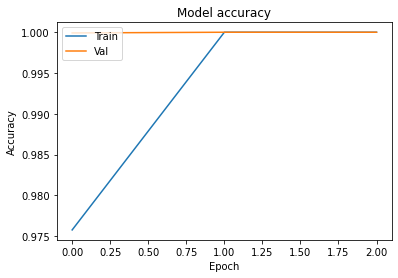

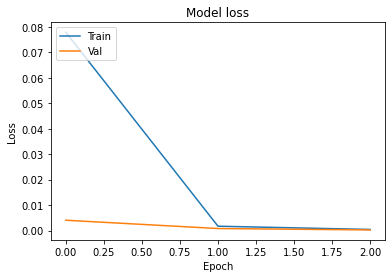

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

with tf.device('/device:GPU:0'):

    # Train the model
    # history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    # Plot the training and validation accuracy over epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig('OE learning accuracy - rnn.png')
    plt.show()

    # Plot the training and validation loss over epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig('OE learning loss - rnn.png')
    plt.show()

### ROC Curve

371/371 [==============================] - 73s 196ms/step


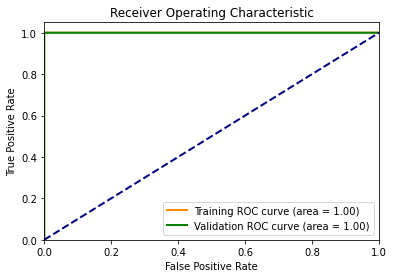

In [8]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, model.predict(X_train)[:,0])
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, model.predict(X_val)[:,0])

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Training ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_val, tpr_val, color='green', lw=2, label='Validation ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('OE roc - rnn.png')
plt.show()


### Precision Recall Curve

371/371 [==============================] - 70s 187ms/step


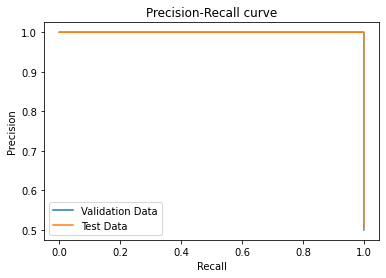

In [9]:
# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop('fraud', axis=1), df['fraud'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


# Make predictions on the validation data
y_val_pred = model.predict(X_val)[:, 0]

# Compute precision and recall values for validation data
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_val_pred)

# Plot the precision-recall curve for validation data
import matplotlib.pyplot as plt
plt.plot(recall_val, precision_val, label='Validation Data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")

# Make predictions on the test data
y_pred = model.predict(X_test)[:, 0]

# Compute precision and recall values for test data
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred)

# Plot the precision-recall curve for test data
plt.plot(recall_test, precision_test, label='Test Data')
plt.legend(loc="lower left")
plt.savefig('OE precision - rnn.png')
plt.show()


### Calibration Curve

297/297 [==============================] - 58s 196ms/step


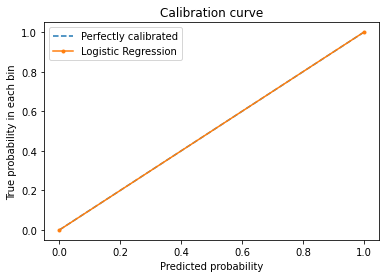

In [10]:
# Get the predicted probabilities
pred_probs = model.predict(X_val)[:, 0]

# Compute the calibration curve
true_prob, pred_prob = calibration_curve(y_val, pred_probs, n_bins=10)

# Visualize the calibration curve
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.plot(pred_prob, true_prob, marker=".", label="Logistic Regression")
plt.xlabel("Predicted probability")
plt.ylabel("True probability in each bin")
plt.title('Calibration curve')
plt.legend()
plt.savefig('OE calibration - rnn.png')
plt.show()


# NN

In [11]:
# Load the dataset
df = pd.read_csv('bank_fraud_dataset_one_hot_encoded.csv')

print(df.columns)

Index(['amount', 'onehotencoder__customer_C1000148617',
       'onehotencoder__customer_C100045114',
       'onehotencoder__customer_C1000699316',
       'onehotencoder__customer_C1001065306',
       'onehotencoder__customer_C1002658784',
       'onehotencoder__customer_C1002759277',
       'onehotencoder__customer_C1004109477',
       'onehotencoder__customer_C1004300450',
       'onehotencoder__customer_C1004532392',
       ...
       'onehotencoder__category_es_leisure',
       'onehotencoder__category_es_otherservices',
       'onehotencoder__category_es_sportsandtoys',
       'onehotencoder__category_es_tech',
       'onehotencoder__category_es_transportation',
       'onehotencoder__category_es_travel',
       'onehotencoder__category_es_wellnessandbeauty', 'remainder__amount',
       'remainder__fraud', 'fraud'],
      dtype='object', length=4080)


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping()
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10, 
    min_delta=0.001, 
    mode='max'
)

In [13]:
import tensorflow as tf
with tf.device('/device:GPU:0'):
    # Split the data into training, validation, and testing sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop('fraud', axis=1), df['fraud'], test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

    # Define the neural network model architecture
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Display the model summary
    model.summary()

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[custom_early_stopping])

    # Evaluate the performance of the model on the test data
    y_pred_test = model.predict(X_test).flatten()
    y_pred_test = np.where(y_pred_test > 0.5, 1, 0)

    print("For Test Dataset")
    print('Accuracy:', accuracy_score(y_test, y_pred_test))
    print('Precision:', precision_score(y_test, y_pred_test))
    print('Recall:', recall_score(y_test, y_pred_test))
    print('F1-score:', f1_score(y_test, y_pred_test))
    print('ROC-AUC:', roc_auc_score(y_test, y_pred_test))
    print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_test))
    print("Classification Report:\n", classification_report(y_test, y_pred_test))

    # Evaluate the performance of the model on the validation data
    y_pred_val = model.predict(X_val).flatten()
    y_pred_val = np.where(y_pred_val > 0.5, 1, 0)

    print("For Validation Dataset")
    print('Accuracy:', accuracy_score(y_val, y_pred_val))
    print('Precision:', precision_score(y_val, y_pred_val))
    print('Recall:', recall_score(y_val, y_pred_val))
    print('F1-score:', f1_score(y_val, y_pred_val))
    print('ROC-AUC:', roc_auc_score(y_val, y_pred_val))
    print('Confusion matrix:\n', confusion_matrix(y_val, y_pred_val))
    print("Classification Report:\n", classification_report(y_val, y_pred_val))

    # Evaluate the performance of the model
    nn_test_acc = accuracy_score(y_test, y_pred_test)
    nn_test_prec = precision_score(y_test, y_pred_test)
    nn_test_rec = recall_score(y_test, y_pred_test)
    nn_test_f1 = f1_score(y_test, y_pred_test)
    nn_test_roc = roc_auc_score(y_test, y_pred_test)

    nn_val_acc = accuracy_score(y_val, y_pred_val)
    nn_val_prec = precision_score(y_val, y_pred_val)
    nn_val_rec = recall_score(y_val, y_pred_val)
    nn_val_f1 = f1_score(y_val, y_pred_val)
    nn_val_roc = roc_auc_score(y_val, y_pred_val)

    with open('OE NN.txt', 'w') as f:
        print("\nNN Performance on Test Data:", file=f)
        print("Accuracy:", nn_test_acc, file=f)
        print("Precision:", nn_test_prec, file=f)
        print("Recall:", nn_test_rec, file=f)
        print("F1-score:", nn_test_f1, file=f)
        print("ROC-AUC:", nn_test_roc, file=f)

        print("\nNN Performance on Validation Data:", file=f)
        print("Accuracy:", nn_val_acc, file=f)
        print("Precision:", nn_val_prec, file=f)
        print("Recall:", nn_val_rec, file=f)
        print("F1-score:", nn_val_f1, file=f)
        print("ROC-AUC:", nn_val_roc, file=f)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 64)                261120    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 261,185
Trainable params: 261,185
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1112/1112 [==============================] - 4s 3ms/step - loss: 0.1318 - accuracy: 0.9604 - val_loss: 0.0266 - val_accuracy: 0.9954
Epoch 2/5
1112/1112 [==============================] - 3s 3ms/step - loss: 0.0220 - accuracy: 0.9956 - val_loss: 0.0069 - val_accuracy: 0.9982
Epoch 3/5
1112/1112 [=====

### Learning Curve

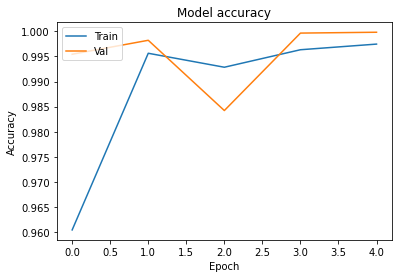

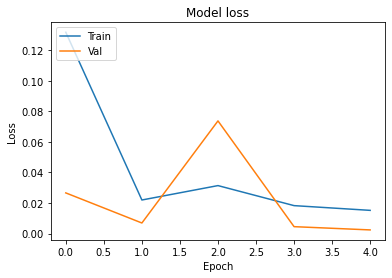

In [14]:
with tf.device('/device:GPU:0'):

    # Train the model
    # history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    # Plot the training and validation accuracy over epochs
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig('OE learning accuracy - nn.png')
    plt.show()

    # Plot the training and validation loss over epochs
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.savefig('OE learning loss - nn.png')
    plt.show()

### ROC Curve

371/371 [==============================] - 0s 949us/step


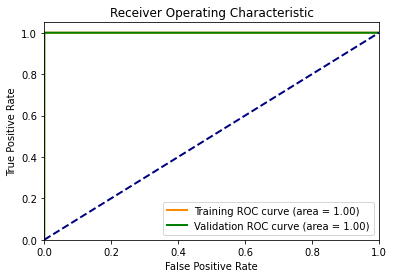

In [15]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, model.predict(X_train)[:,0])
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, model.predict(X_val)[:,0])

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Training ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_val, tpr_val, color='green', lw=2, label='Validation ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('OE roc - nn.png')
plt.show()


### Precision Recall Curve

371/371 [==============================] - 0s 846us/step


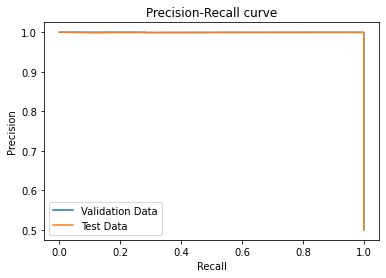

In [16]:
# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop('fraud', axis=1), df['fraud'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)


# Make predictions on the validation data
y_val_pred = model.predict(X_val)[:, 0]

# Compute precision and recall values for validation data
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_val_pred)

# Plot the precision-recall curve for validation data
import matplotlib.pyplot as plt
plt.plot(recall_val, precision_val, label='Validation Data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")

# Make predictions on the test data
y_pred = model.predict(X_test)[:, 0]

# Compute precision and recall values for test data
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred)

# Plot the precision-recall curve for test data
plt.plot(recall_test, precision_test, label='Test Data')
plt.legend(loc="lower left")
plt.savefig('OE precision - nn.png')
plt.show()


### Calibration Curve

297/297 [==============================] - 0s 884us/step


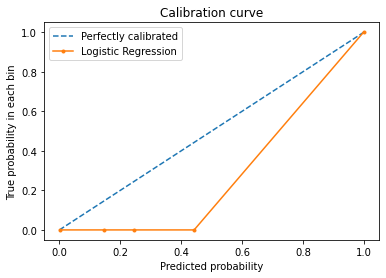

In [17]:
# Get the predicted probabilities
pred_probs = model.predict(X_val)[:, 0]

# Compute the calibration curve
true_prob, pred_prob = calibration_curve(y_val, pred_probs, n_bins=10)

# Visualize the calibration curve
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.plot(pred_prob, true_prob, marker=".", label="Logistic Regression")
plt.xlabel("Predicted probability")
plt.ylabel("True probability in each bin")
plt.title('Calibration curve')
plt.legend()
plt.savefig('OE calibration - nn.png')
plt.show()


# Logistic Regression

In [18]:
# Load the dataset
df = pd.read_csv('bank_fraud_dataset_one_hot_encoded.csv')

print(df.columns)

Index(['amount', 'onehotencoder__customer_C1000148617',
       'onehotencoder__customer_C100045114',
       'onehotencoder__customer_C1000699316',
       'onehotencoder__customer_C1001065306',
       'onehotencoder__customer_C1002658784',
       'onehotencoder__customer_C1002759277',
       'onehotencoder__customer_C1004109477',
       'onehotencoder__customer_C1004300450',
       'onehotencoder__customer_C1004532392',
       ...
       'onehotencoder__category_es_leisure',
       'onehotencoder__category_es_otherservices',
       'onehotencoder__category_es_sportsandtoys',
       'onehotencoder__category_es_tech',
       'onehotencoder__category_es_transportation',
       'onehotencoder__category_es_travel',
       'onehotencoder__category_es_wellnessandbeauty', 'remainder__amount',
       'remainder__fraud', 'fraud'],
      dtype='object', length=4080)


In [19]:
from sklearn.linear_model import LogisticRegression

# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop('fraud', axis=1), df['fraud'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Define the parameter grid to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Create the grid search object
grid_search = GridSearchCV(
    LogisticRegression(solver='liblinear'),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best accuracy
print('Best parameters:', grid_search.best_params_)
print('Best accuracy:', grid_search.best_score_)

# Train the logistic regression model with the best hyperparameters
best_model = LogisticRegression(solver='liblinear', **grid_search.best_params_)
best_model.fit(X_train, y_train)

# Make predictions on the test and validation data
y_pred_test = best_model.predict(X_test)
y_pred_val = best_model.predict(X_val)

# Evaluate the performance of the logistic regression model on the test and validation data
log_test_acc = accuracy_score(y_test, y_pred_test)
log_test_prec = precision_score(y_test, y_pred_test)
log_test_rec = recall_score(y_test, y_pred_test)
log_test_f1 = f1_score(y_test, y_pred_test)
log_test_roc = roc_auc_score(y_test, y_pred_test)

log_val_acc = accuracy_score(y_val, y_pred_val)
log_val_prec = precision_score(y_val, y_pred_val)
log_val_rec = recall_score(y_val, y_pred_val)
log_val_f1 = f1_score(y_val, y_pred_val)
log_val_roc = roc_auc_score(y_val, y_pred_val)

# Evaluate the performance of the gradient boosting classifier
print("For Test Dataset")
print('Accuracy:', log_test_acc)
print('Precision:', log_test_prec)
print('Recall:', log_test_rec)
print('F1-score:', log_test_f1)
print('ROC-AUC:', log_test_roc)
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Evaluate the performance of the gradient boosting classifier
print("For Validation Dataset")
print('Accuracy:', log_val_acc)
print('Precision:', log_val_prec)
print('Recall:', log_val_rec)
print('F1-score:', log_val_f1)
print('ROC-AUC:', log_val_roc)
print('Confusion matrix:\n', confusion_matrix(y_val, y_pred_val))
print("Classification Report:\n", classification_report(y_val, y_pred_val))

with open('OE Logistic Regression.txt', 'w') as f:
    print("\nLogistic Regression Performance on Test Data:", file=f)
    print("Accuracy:", log_test_acc, file=f)
    print("Precision:", log_test_prec, file=f)
    print("Recall:", log_test_rec, file=f)
    print("F1-score:", log_test_f1, file=f)
    print("ROC-AUC:", log_test_roc, file=f)

    print("\nLogistic Regression Performance on Validation Data:", file=f)
    print("Accuracy:", log_val_acc, file=f)
    print("Precision:", log_val_prec, file=f)
    print("Recall:", log_val_rec, file=f)
    print("F1-score:", log_val_f1, file=f)
    print("ROC-AUC:", log_val_roc, file=f)

Best parameters: {'C': 0.1, 'penalty': 'l1'}
Best accuracy: 0.9999718785151857
For Test Dataset
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0
Confusion matrix:
 [[5906    0]
 [   0 5947]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5906
           1       1.00      1.00      1.00      5947

    accuracy                           1.00     11853
   macro avg       1.00      1.00      1.00     11853
weighted avg       1.00      1.00      1.00     11853

For Validation Dataset
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0
Confusion matrix:
 [[5924    0]
 [   0 5929]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5924
           1       1.00      1.00      1.00      5929

    accuracy                           1.00     11853
   macro avg       1.00      1.00      1.00     11853
weight

### Learning Curve

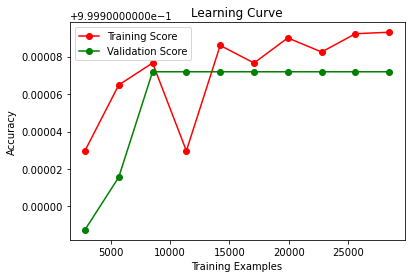

In [20]:
# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Validation Score')
plt.legend(loc='best')
plt.savefig('OE learning - log.png')


### ROC Curve

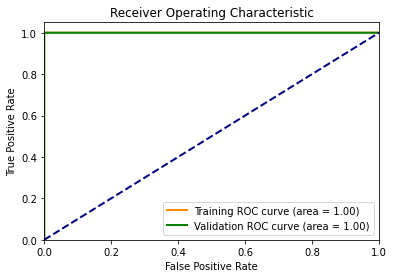

In [21]:
# Plot the ROC curves for the training and validation sets
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, best_model.predict_proba(X_train)[:,1])
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, best_model.predict_proba(X_val)[:,1])

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Training ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_val, tpr_val, color='green', lw=2, label='Validation ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('OE roc - log.png')
plt.show()


### Precision Recall Curve

/home/et-lambda/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


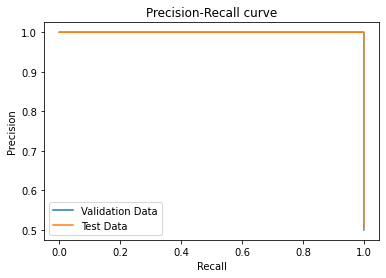

In [22]:
# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop('fraud', axis=1), df['fraud'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the validation data
y_val_pred = model.predict_proba(X_val)[:, 1]

# Compute precision and recall values for validation data
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_val_pred)

# Plot the precision-recall curve for validation data
import matplotlib.pyplot as plt
plt.plot(recall_val, precision_val, label='Validation Data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")

# Make predictions on the test data
y_pred = model.predict_proba(X_test)[:, 1]

# Compute precision and recall values for test data
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred)

# Plot the precision-recall curve for test data
plt.plot(recall_test, precision_test, label='Test Data')
plt.legend(loc="lower left")
plt.savefig('OE precission - log.png')
plt.show()


### Calibration Curve

/home/et-lambda/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


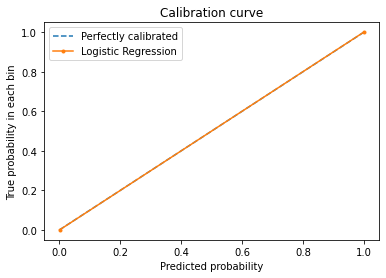

In [23]:
# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Get the predicted probabilities
pred_probs = model.predict_proba(X_val)[:, 1]

# Compute the calibration curve
true_prob, pred_prob = calibration_curve(y_val, pred_probs, n_bins=10)

# Visualize the calibration curve
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.plot(pred_prob, true_prob, marker=".", label="Logistic Regression")
plt.xlabel("Predicted probability")
plt.ylabel("True probability in each bin")
plt.title('Calibration curve')
plt.legend()
plt.savefig('OE calibration - log.png')
plt.show()


# Gradient Boosting

In [24]:
import pandas as pd
# Load the dataset
df = pd.read_csv('bank_fraud_dataset_one_hot_encoded.csv')

print(df.columns)


Index(['amount', 'onehotencoder__customer_C1000148617',
       'onehotencoder__customer_C100045114',
       'onehotencoder__customer_C1000699316',
       'onehotencoder__customer_C1001065306',
       'onehotencoder__customer_C1002658784',
       'onehotencoder__customer_C1002759277',
       'onehotencoder__customer_C1004109477',
       'onehotencoder__customer_C1004300450',
       'onehotencoder__customer_C1004532392',
       ...
       'onehotencoder__category_es_leisure',
       'onehotencoder__category_es_otherservices',
       'onehotencoder__category_es_sportsandtoys',
       'onehotencoder__category_es_tech',
       'onehotencoder__category_es_transportation',
       'onehotencoder__category_es_travel',
       'onehotencoder__category_es_wellnessandbeauty', 'remainder__amount',
       'remainder__fraud', 'fraud'],
      dtype='object', length=4080)


In [25]:
from sklearn.ensemble import GradientBoostingClassifier

# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop('fraud', axis=1), df['fraud'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.2]
}

# Create the grid search object
grid_search = GridSearchCV(
    GradientBoostingClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best accuracy
print('Best parameters:', grid_search.best_params_)
print('Best accuracy:', grid_search.best_score_)

# Train the gradient boosting classifier with the best hyperparameters
best_model = GradientBoostingClassifier(**grid_search.best_params_)
best_model.fit(X_train, y_train)

# Make predictions on the test and validation data
y_pred_test = best_model.predict(X_test)
y_pred_val = best_model.predict(X_val)

# Evaluate the performance of the logistic regression model on the test and validation data
gb_test_acc = accuracy_score(y_test, y_pred_test)
gb_test_prec = precision_score(y_test, y_pred_test)
gb_test_rec = recall_score(y_test, y_pred_test)
gb_test_f1 = f1_score(y_test, y_pred_test)
gb_test_roc = roc_auc_score(y_test, y_pred_test)

gb_val_acc = accuracy_score(y_val, y_pred_val)
gb_val_prec = precision_score(y_val, y_pred_val)
gb_val_rec = recall_score(y_val, y_pred_val)
gb_val_f1 = f1_score(y_val, y_pred_val)
gb_val_roc = roc_auc_score(y_val, y_pred_val)

# Evaluate the performance of the gradient boosting classifier
print("For Test Dataset")
print('Accuracy:', gb_test_acc)
print('Precision:', gb_test_prec)
print('Recall:', gb_test_rec)
print('F1-score:', gb_test_f1)
print('ROC-AUC:', gb_test_roc)
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Evaluate the performance of the gradient boosting classifier
print("For Validation Dataset")
print('Accuracy:', gb_val_acc)
print('Precision:', gb_val_prec)
print('Recall:', gb_val_rec)
print('F1-score:', gb_val_f1)
print('ROC-AUC:', gb_val_roc)
print('Confusion matrix:\n', confusion_matrix(y_val, y_pred_val))
print("Classification Report:\n", classification_report(y_val, y_pred_val))

with open('OE Gradient Boosting.txt', 'w') as f:
    print("\nGradient Boosting Performance on Test Data:", file=f)
    print("Accuracy:", gb_test_acc, file=f)
    print("Precision:", gb_test_prec, file=f)
    print("Recall:", gb_test_rec, file=f)
    print("F1-score:", gb_test_f1, file=f)
    print("ROC-AUC:", gb_test_roc, file=f)

    print("\nGradient Boosting Pegbormance on Validation Data:", file=f)
    print("Accuracy:", gb_val_acc, file=f)
    print("Precision:", gb_val_prec, file=f)
    print("Recall:", gb_val_rec, file=f)
    print("F1-score:", gb_val_f1, file=f)
    print("ROC-AUC:", gb_val_roc, file=f)

Best parameters: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 50}
Best accuracy: 1.0
For Test Dataset
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0
Confusion matrix:
 [[5906    0]
 [   0 5947]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5906
           1       1.00      1.00      1.00      5947

    accuracy                           1.00     11853
   macro avg       1.00      1.00      1.00     11853
weighted avg       1.00      1.00      1.00     11853

For Validation Dataset
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
ROC-AUC: 1.0
Confusion matrix:
 [[5924    0]
 [   0 5929]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5924
           1       1.00      1.00      1.00      5929

    accuracy                           1.00     11853
   macro avg       1.00      1.00      1.00

### Learning Curve

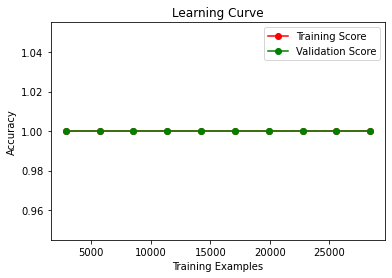

In [26]:
# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Validation Score')
plt.legend(loc='best')
plt.savefig('OE learning - gb.png')

### ROC Curve

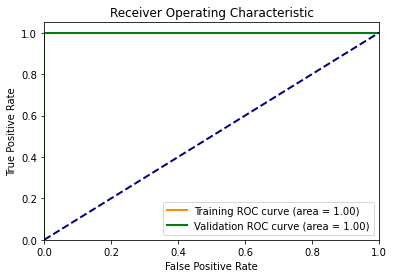

In [27]:
# Fit the Gradient Boosting classifier
model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
model.fit(X_train, y_train)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, best_model.predict_proba(X_train)[:,1])
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, best_model.predict_proba(X_val)[:,1])

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Training ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_val, tpr_val, color='green', lw=2, label='Validation ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('OE roc - gb.png')
plt.show()


### Precision Recall Curve

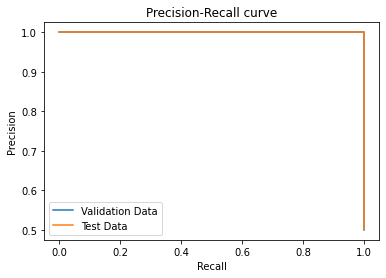

In [28]:
# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop('fraud', axis=1), df['fraud'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Fit the logistic regression model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# Make predictions on the validation data
y_val_pred = model.predict_proba(X_val)[:, 1]

# Compute precision and recall values for validation data
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_val_pred)

# Plot the precision-recall curve for validation data
import matplotlib.pyplot as plt
plt.plot(recall_val, precision_val, label='Validation Data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")

# Make predictions on the test data
y_pred = model.predict_proba(X_test)[:, 1]

# Compute precision and recall values for test data
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred)

# Plot the precision-recall curve for test data
plt.plot(recall_test, precision_test, label='Test Data')
plt.legend(loc="lower left")
plt.savefig('OE precision - gb.png')
plt.show()


### Calibration Curve

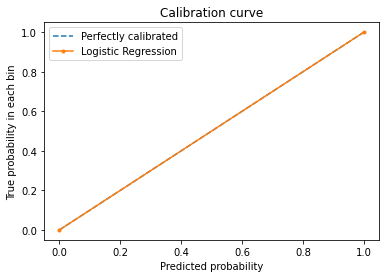

In [29]:
# Fit the Gradient Boosting model
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# Get the predicted probabilities
pred_probs = model.predict_proba(X_val)[:, 1]

# Compute the calibration curve
true_prob, pred_prob = calibration_curve(y_val, pred_probs, n_bins=10)

# Visualize the calibration curve
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.plot(pred_prob, true_prob, marker=".", label="Logistic Regression")
plt.xlabel("Predicted probability")
plt.ylabel("True probability in each bin")
plt.title('Calibration curve')
plt.legend()
plt.savefig('OE calibration - gb.png')
plt.show()


# Random Forest

In [30]:
# Load the dataset
df = pd.read_csv('bank_fraud_dataset_one_hot_encoded.csv')

print(df.columns)


Index(['amount', 'onehotencoder__customer_C1000148617',
       'onehotencoder__customer_C100045114',
       'onehotencoder__customer_C1000699316',
       'onehotencoder__customer_C1001065306',
       'onehotencoder__customer_C1002658784',
       'onehotencoder__customer_C1002759277',
       'onehotencoder__customer_C1004109477',
       'onehotencoder__customer_C1004300450',
       'onehotencoder__customer_C1004532392',
       ...
       'onehotencoder__category_es_leisure',
       'onehotencoder__category_es_otherservices',
       'onehotencoder__category_es_sportsandtoys',
       'onehotencoder__category_es_tech',
       'onehotencoder__category_es_transportation',
       'onehotencoder__category_es_travel',
       'onehotencoder__category_es_wellnessandbeauty', 'remainder__amount',
       'remainder__fraud', 'fraud'],
      dtype='object', length=4080)


In [31]:
from sklearn.ensemble import RandomForestClassifier

# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop('fraud', axis=1), df['fraud'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

# Create the grid search object
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Perform the grid search to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the best accuracy
print('Best parameters:', grid_search.best_params_)
print('Best accuracy:', grid_search.best_score_)

# Train the random forest model with the best hyperparameters
best_model = RandomForestClassifier(random_state=42, **grid_search.best_params_)
best_model.fit(X_train, y_train)

# Make predictions on the test and validation data
y_pred_test = best_model.predict(X_test)
y_pred_val = best_model.predict(X_val)

# Evaluate the performance of the logistic regression model on the test and validation data
rf_test_acc = accuracy_score(y_test, y_pred_test)
rf_test_prec = precision_score(y_test, y_pred_test)
rf_test_rec = recall_score(y_test, y_pred_test)
rf_test_f1 = f1_score(y_test, y_pred_test)
rf_test_roc = roc_auc_score(y_test, y_pred_test)

rf_val_acc = accuracy_score(y_val, y_pred_val)
rf_val_prec = precision_score(y_val, y_pred_val)
rf_val_rec = recall_score(y_val, y_pred_val)
rf_val_f1 = f1_score(y_val, y_pred_val)
rf_val_roc = roc_auc_score(y_val, y_pred_val)

# Evaluate the performance of the gradient boosting classifier
print("For Test Dataset")
print('Accuracy:', rf_test_acc)
print('Precision:', rf_test_prec)
print('Recall:', rf_test_rec)
print('F1-score:', rf_test_f1)
print('ROC-AUC:', rf_test_roc)
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

# Evaluate the performance of the gradient boosting classifier
print("For Validation Dataset")
print('Accuracy:', rf_val_acc)
print('Precision:', rf_val_prec)
print('Recall:', rf_val_rec)
print('F1-score:', rf_val_f1)
print('ROC-AUC:', rf_val_roc)
print('Confusion matrix:\n', confusion_matrix(y_val, y_pred_val))
print("Classification Report:\n", classification_report(y_val, y_pred_val))

with open('OE Random Forest.txt', 'w') as f:
    print("\nRandom Forest Performance on Test Data:", file=f)
    print("Accuracy:", rf_test_acc, file=f)
    print("Precision:", rf_test_prec, file=f)
    print("Recall:", rf_test_rec, file=f)
    print("F1-score:", rf_test_f1, file=f)
    print("ROC-AUC:", rf_test_roc, file=f)

    print("\nRandom Forest Performance on Validation Data:", file=f)
    print("Accuracy:", rf_val_acc, file=f)
    print("Precision:", rf_val_prec, file=f)
    print("Recall:", rf_val_rec, file=f)
    print("F1-score:", rf_val_f1, file=f)
    print("ROC-AUC:", rf_val_roc, file=f)


Best parameters: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 100}
Best accuracy: 0.9934753409655883
For Test Dataset
Accuracy: 0.9975533620180544
Precision: 0.9959772041568891
Recall: 0.9991592399529174
F1-score: 0.997565684546294
ROC-AUC: 0.9975477879412403
Confusion matrix:
 [[5882   24]
 [   5 5942]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      5906
           1       1.00      1.00      1.00      5947

    accuracy                           1.00     11853
   macro avg       1.00      1.00      1.00     11853
weighted avg       1.00      1.00      1.00     11853

For Validation Dataset
Accuracy: 0.9967096937484181
Precision: 0.9944593687038281
Recall: 0.998988024962051
F1-score: 0.9967185527976441
ROC-AUC: 0.9967087322649553
Confusion matrix:
 [[5891   33]
 [   6 5923]]
Classification Report:
               precision    recall  f1-score   support

           0      

### Learning Curve

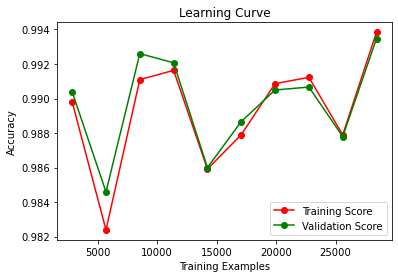

In [32]:
# Plot the learning curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
plt.figure()
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='r', label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color='g', label='Validation Score')
plt.legend(loc='best')
plt.savefig('OE learning - rf.png')

### ROC Curve

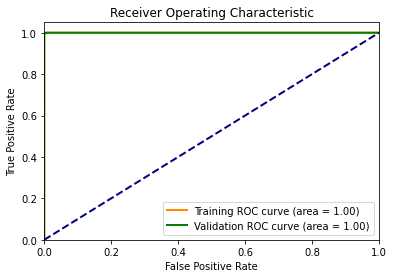

In [33]:
# Fit the random forest classifier
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, best_model.predict_proba(X_train)[:,1])
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, best_model.predict_proba(X_val)[:,1])

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)

plt.figure()
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label='Training ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot(fpr_val, tpr_val, color='green', lw=2, label='Validation ROC curve (area = %0.2f)' % roc_auc_val)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('OE roc - rf.png')
plt.show()


### Precision Recall

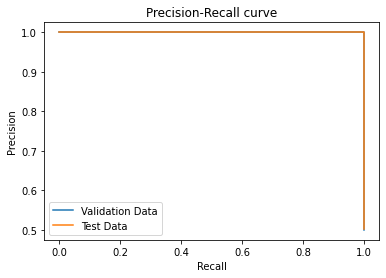

In [34]:
# Split the data into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(df.drop('fraud', axis=1), df['fraud'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Fit the logistic regression model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Make predictions on the validation data
y_val_pred = model.predict_proba(X_val)[:, 1]

# Compute precision and recall values for validation data
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, y_val_pred)

# Plot the precision-recall curve for validation data
import matplotlib.pyplot as plt
plt.plot(recall_val, precision_val, label='Validation Data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")

# Make predictions on the test data
y_pred = model.predict_proba(X_test)[:, 1]

# Compute precision and recall values for test data
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, y_pred)

# Plot the precision-recall curve for test data
plt.plot(recall_test, precision_test, label='Test Data')
plt.legend(loc="lower left")
plt.savefig('OE precision - rf.png')
plt.show()


### Calibration Curve

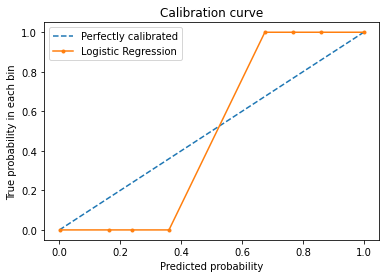

In [35]:
# Fit the Gradient Boosting model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Get the predicted probabilities
pred_probs = model.predict_proba(X_val)[:, 1]

# Compute the calibration curve
true_prob, pred_prob = calibration_curve(y_val, pred_probs, n_bins=10)

# Visualize the calibration curve
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.plot(pred_prob, true_prob, marker=".", label="Logistic Regression")
plt.xlabel("Predicted probability")
plt.ylabel("True probability in each bin")
plt.title('Calibration curve')
plt.legend()
plt.savefig('OE calibration - rf.png')
plt.show()


# Analysis

### Wilcoxon Test

In [36]:
from scipy.stats import wilcoxon
import numpy as np

# Two arrays of sample data
algorithm1_scores = [rnn_test_acc, rnn_test_prec, rnn_test_rec, rnn_test_f1, rnn_test_roc]
algorithm2_scores = [nn_test_acc, nn_test_prec, nn_test_rec, nn_test_f1, nn_test_roc]
algorithm3_scores = [log_test_acc, log_test_prec, log_test_rec, log_test_f1, log_test_roc]
algorithm4_scores = [gb_test_acc, gb_test_prec, gb_test_rec, gb_test_f1, gb_test_roc]
algorithm5_scores = [rf_test_acc, rf_test_prec, rf_test_rec, rf_test_f1, rf_test_roc]

# Perform the Wilcoxon signed-rank test for each pair of algorithms
results = []
for i in range(1, 6):
    for j in range(i+1, 6):
        statistic, p_value = wilcoxon(eval(f"algorithm{i}_scores"), eval(f"algorithm{j}_scores"), zero_method='zsplit')
        result = f"Test statistic for algorithms {i} and {j}: {statistic}\n"
        result += f"P-value for algorithms {i} and {j}: {p_value}\n"
        print(f"Test statistic for algorithms {i} and {j}:", statistic)
        print(f"P-value for algorithms {i} and {j}:", p_value)
        if p_value < 0.05:
            result += f"There is a significant difference between algorithms {i} and {j}.\n"
            print(f"There is a significant difference between algorithms {i} and {j}.\n")
        else:
            result += f"There is no significant difference between algorithms {i} and {j}.\n"
            print(f"There is no significant difference between algorithms {i} and {j}.\n")
        results.append(result)

# Save the output to a text file
with open('OE wilcoxon_test_results.txt', 'w') as f:
    f.write("Results of Wilcoxon signed-rank tests:\n\n")
    f.writelines(results)


Test statistic for algorithms 1 and 2: 0.5
P-value for algorithms 1 and 2: 0.05905822909053671
There is no significant difference between algorithms 1 and 2.

Test statistic for algorithms 1 and 3: 7.5
P-value for algorithms 1 and 3: 1.0
There is no significant difference between algorithms 1 and 3.

Test statistic for algorithms 1 and 4: 7.5
P-value for algorithms 1 and 4: 1.0
There is no significant difference between algorithms 1 and 4.

Test statistic for algorithms 1 and 5: 0.0
P-value for algorithms 1 and 5: 0.0625
There is no significant difference between algorithms 1 and 5.

Test statistic for algorithms 2 and 3: 0.5
P-value for algorithms 2 and 3: 0.05905822909053671
There is no significant difference between algorithms 2 and 3.

Test statistic for algorithms 2 and 4: 0.5
P-value for algorithms 2 and 4: 0.05905822909053671
There is no significant difference between algorithms 2 and 4.

Test statistic for algorithms 2 and 5: 0.0
P-value for algorithms 2 and 5: 0.0625
There is 

/usr/lib/python3/dist-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/lib/python3/dist-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Statistical Analysis of all the accuracies

In [37]:
from scipy import stats
import numpy as np

# Create a list of classifiers and their corresponding performance metrics
classifiers = ['RNN', 'NN', 'Logistic Regression', 'Gradient Boosting', 'Random Forest']
accuracies = [rnn_test_acc, nn_test_acc, log_test_acc, gb_test_acc, rf_test_acc]

# Calculate the mean and standard deviation of the accuracies
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

# Calculate the t-statistic and p-value
t_stat, p_val = stats.ttest_1samp(accuracies, 0.5)

# Print the results
print("Mean accuracy: {:.4f}".format(mean_acc))
print("Standard deviation: {:.4f}".format(std_acc))
print("T-statistic: {:.4f}".format(t_stat))
print("P-value: {:.4f}".format(p_val))

# Save the output to a text file
with open('OE classifier_metrics.txt', 'w') as f:
    f.write("Mean accuracy: {:.4f}\n".format(mean_acc))
    f.write("Standard deviation: {:.4f}\n".format(std_acc))
    f.write("T-statistic: {:.4f}\n".format(t_stat))
    f.write("P-value: {:.4f}\n".format(p_val))


Mean accuracy: 0.9994
Standard deviation: 0.0010
T-statistic: 1047.1550
P-value: 0.0000


### Friedman Chi Square Test

In [38]:
from scipy.stats import friedmanchisquare

# define the performance metrics for comparison
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# create a dictionary to store the results
results = {}
for metric in metrics:
    results[metric] = []

# append the performance of each algorithm for each metric
results['accuracy'].append(rnn_test_acc)
results['precision'].append(rnn_test_prec)
results['recall'].append(rnn_test_rec)
results['f1'].append(rnn_test_f1)
results['roc_auc'].append(rnn_test_roc)

results['accuracy'].append(nn_test_acc)
results['precision'].append(nn_test_prec)
results['recall'].append(nn_test_rec)
results['f1'].append(nn_test_f1)
results['roc_auc'].append(nn_test_roc)

results['accuracy'].append(log_test_acc)
results['precision'].append(log_test_prec)
results['recall'].append(log_test_rec)
results['f1'].append(log_test_f1)
results['roc_auc'].append(log_test_roc)

results['accuracy'].append(gb_test_acc)
results['precision'].append(gb_test_prec)
results['recall'].append(gb_test_rec)
results['f1'].append(gb_test_f1)
results['roc_auc'].append(gb_test_roc)

results['accuracy'].append(rf_test_acc)
results['precision'].append(rf_test_prec)
results['recall'].append(rf_test_rec)
results['f1'].append(rf_test_f1)
results['roc_auc'].append(rf_test_roc)

# perform Friedman test
stat, p = friedmanchisquare(*results.values())

print('Friedman Test:')
print(f'Test statistic: {stat:.4f}')
print(f'p-value: {p:.4f}')
if p < 0.05:
    print('There is a significant difference between the algorithms.')
else:
    print('There is no significant difference between the algorithms.')


# Save output to a text file
with open('OE friedman_test_results.txt', 'w') as f:
    f.write('Friedman Test:\n')
    f.write(f'Test statistic: {stat:.4f}\n')
    f.write(f'p-value: {p:.4f}\n')
    if p < 0.05:
        f.write('There is a significant difference between the algorithms.\n')
    else:
        f.write('There is no significant difference between the algorithms.\n')


Friedman Test:
Test statistic: 8.0000
p-value: 0.0916
There is no significant difference between the algorithms.


### Displaying the metrics for all the algorithms

In [39]:
# Create a dictionary to store the accuracies of each model
models_acc = {"Logistic Regression": log_test_acc,
              "Gradient Boosting": gb_test_acc,
              "Random Forest": rf_test_acc,
              "RNN": rnn_test_acc,
              "NN": nn_test_acc}

# Convert the dictionary into a Pandas DataFrame
df_acc = pd.DataFrame.from_dict(models_acc, orient='index')
print()
print()
print("Accuracies")
print(df_acc)

# Create a dictionary to store the precision of each model
models_prec = {"Logistic Regression": log_test_prec,
              "Gradient Boosting": gb_test_prec,
              "Random Forest": rf_test_prec,
              "RNN": rnn_test_prec,
              "NN": nn_test_prec}

# Convert the dictionary into a Pandas DataFrame
df_prec = pd.DataFrame.from_dict(models_prec, orient='index')
print()
print()
print("Precision")
print(df_prec)

# Create a dictionary to store the recall of each model
models_rec = {"Logistic Regression": log_test_rec,
              "Gradient Boosting": gb_test_rec,
              "Random Forest": rf_test_rec,
              "RNN": rnn_test_rec,
              "NN": nn_test_rec}

# Convert the dictionary into a Pandas DataFrame
df_rec = pd.DataFrame.from_dict(models_rec, orient='index')
print()
print()
print("Recall")
print(df_rec)

# Create a dictionary to store the f1 of each model
models_f1 = {"Logistic Regression": log_test_f1,
              "Gradient Boosting": gb_test_f1,
              "Random Forest": rf_test_f1,
              "RNN": rnn_test_f1,
              "NN": nn_test_f1}

# Convert the dictionary into a Pandas DataFrame
df_f1 = pd.DataFrame.from_dict(models_f1, orient='index')
print()
print()
print("f1")
print(df_f1)

# Create a dictionary to store the ROC of each model
models_roc = {"Logistic Regression": log_test_roc,
              "Gradient Boosting": gb_test_roc,
              "Random Forest": rf_test_roc,
              "RNN": rnn_test_roc,
              "NN": nn_test_roc}

# Convert the dictionary into a Pandas DataFrame
df_roc = pd.DataFrame.from_dict(models_roc, orient='index')
print()
print()
print("ROC")
print(df_roc)

with open('OE Metrics.txt', 'w') as f:
    print("Accuracies", file=f)
    print(df_acc, file=f)
    
    print("Precision", file=f)
    print(df_prec, file=f)
    
    print("Recall", file=f)
    print(df_rec, file=f)
    
    print("f1", file=f)
    print(df_f1, file=f)
    
    print("ROC", file=f)
    print(df_roc, file=f)




Accuracies
                            0
Logistic Regression  1.000000
Gradient Boosting    1.000000
Random Forest        0.997553
RNN                  1.000000
NN                   0.999663


Precision
                            0
Logistic Regression  1.000000
Gradient Boosting    1.000000
Random Forest        0.995977
RNN                  1.000000
NN                   0.999328


Recall
                            0
Logistic Regression  1.000000
Gradient Boosting    1.000000
Random Forest        0.999159
RNN                  1.000000
NN                   1.000000


f1
                            0
Logistic Regression  1.000000
Gradient Boosting    1.000000
Random Forest        0.997566
RNN                  1.000000
NN                   0.999664


ROC
                            0
Logistic Regression  1.000000
Gradient Boosting    1.000000
Random Forest        0.997548
RNN                  1.000000
NN                   0.999661


### Plotting the metrics for each algorithm

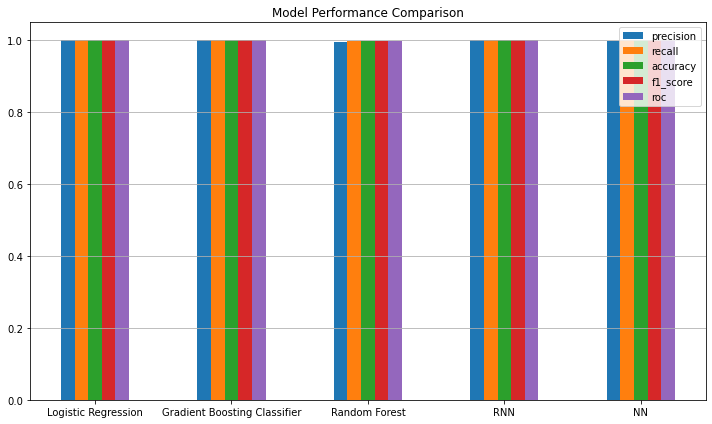

In [40]:
# Define model names and performance metrics
models = {
    'Logistic Regression': {'precision': log_test_prec, 'recall': log_test_rec, 'accuracy': log_test_acc, 'f1_score': log_test_f1, 'roc': log_test_roc},
    'Gradient Boosting Classifier': {'precision': gb_test_prec, 'recall': gb_test_rec, 'accuracy': gb_test_acc, 'f1_score': gb_test_f1, 'roc': gb_test_roc},
    'Random Forest': {'precision': rf_test_prec, 'recall': rf_test_rec, 'accuracy': rf_test_acc, 'f1_score': rf_test_f1, 'roc': rf_test_roc},
    'RNN': {'precision': rnn_test_prec, 'recall': rnn_test_rec, 'accuracy': rnn_test_acc, 'f1_score': rnn_test_f1, 'roc': rnn_test_roc},
    'NN': {'precision': nn_test_prec, 'recall': nn_test_rec, 'accuracy': nn_test_acc, 'f1_score': nn_test_f1, 'roc': nn_test_roc}
}

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.1
x_pos = np.arange(len(models))
metrics = list(models['Logistic Regression'].keys())

for i, metric in enumerate(metrics):
    values = [model[metric] for model in models.values()]
    ax.bar(x_pos + (i - 2) * width, values, width, label=metric)

ax.set_xticks(x_pos)
ax.set_xticklabels(models.keys())
ax.legend()
ax.yaxis.grid(True)
ax.set_title('Model Performance Comparison')
plt.tight_layout()
plt.savefig("OE Performance Comparison.png")
plt.show()


### Comparing the models against each metric

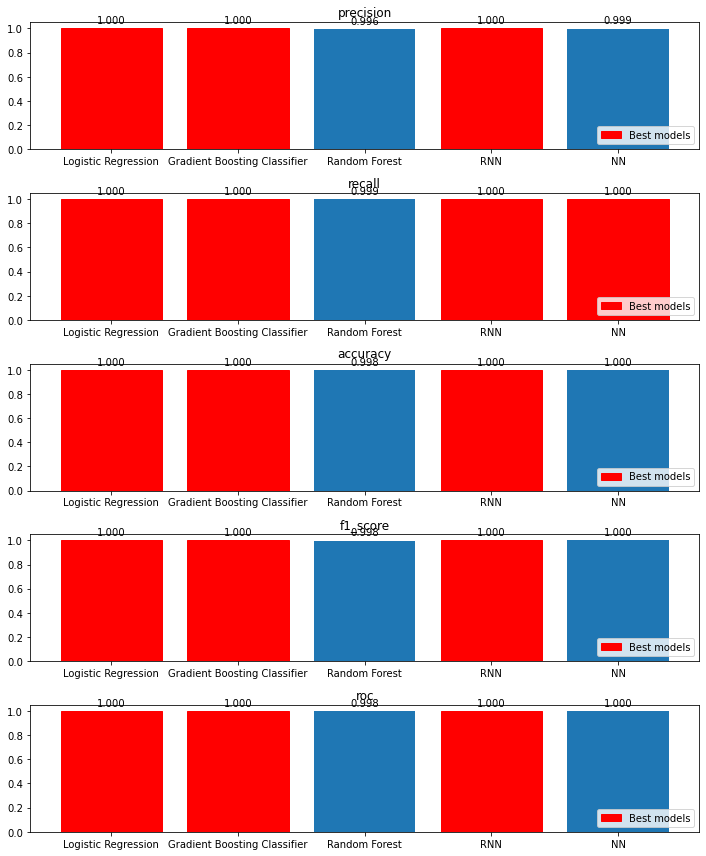

In [41]:
# Define model names and performance metrics
models = {
    'Logistic Regression': {'precision': log_test_prec, 'recall': log_test_rec, 'accuracy': log_test_acc, 'f1_score': log_test_f1, 'roc': log_test_roc},
    'Gradient Boosting Classifier': {'precision': gb_test_prec, 'recall': gb_test_rec, 'accuracy': gb_test_acc, 'f1_score': gb_test_f1, 'roc': gb_test_roc},
    'Random Forest': {'precision': rf_test_prec, 'recall': rf_test_rec, 'accuracy': rf_test_acc, 'f1_score': rf_test_f1, 'roc': rf_test_roc},
    'RNN': {'precision': rnn_test_prec, 'recall': rnn_test_rec, 'accuracy': rnn_test_acc, 'f1_score': rnn_test_f1, 'roc': rnn_test_roc},
    'NN': {'precision': nn_test_prec, 'recall': nn_test_rec, 'accuracy': nn_test_acc, 'f1_score': nn_test_f1, 'roc': nn_test_roc}
}

# Create subplots for each metric
metrics = list(models['Logistic Regression'].keys())
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(10, 12))

# Plot each metric
for i, metric in enumerate(metrics):
    values = [model[metric] for model in models.values()]
    rects = axes[i].bar(models.keys(), values)
    axes[i].set_title(metric)

    # Highlight tallest bars
    max_val = max(values)
    max_indices = [index for index, value in enumerate(values) if value == max_val]
    for index in max_indices:
        rects[index].set_color('red')

    # Add legend
    axes[i].legend(tuple(rects[index] for index in max_indices), ('Best models',), loc='lower right')

    # Add value annotations
    for rect in rects:
        height = rect.get_height()
        axes[i].annotate(f'{height:.3f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("OE Best Model.png")
plt.show()
